Get Mean pCO2 from a previous reconstruction products

Calc pCO2-T from mean pCO2 and SST

Calc pCO2-DIC from SOCAT observations of pCO2 and calculated pCO2-T 

In [1]:
socat_dir = "/data/artemis/workspace/vbennington/SOCAT/processed"

In [3]:
# Import Modules

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import skill_metrics as sm
from collections import defaultdict
import pickle
import joblib
from keras.models import load_model

import seaborn as sns
import cmocean as cm            # really nice colorbars
import matplotlib.pyplot as plt # for making plots
#%run "../_define_model_class.ipynb"
#%run "../_Val_Mapping.ipynb"

#import pre

In [15]:
# Mean pCO2
# Have 5 runs of train/test different years (Gregor Years)
# Use mean of these 5 reconstructions

products = xr.load_dataset('/local/data/artemis/workspace/gloege/gregor/pco2_products_standardised.nc')
prod_name = ['mpisomffn','jmamlr','jenamls','lsceffnn2','niesfnn','csirml6']  

In [16]:
pco2_all = np.empty(shape=(6,180,360))

for i in range(0,len(prod_name)):
    pco2_all[i,:,:] = products[f"{prod_name[i]}"].mean("time")
    
pco2_mean = np.nanmean(pco2_all,axis=0)

/home/vbennington/.conda/envs/dev2/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  


Text(0.5,1,'Mean pCO2 (1985-2018)')

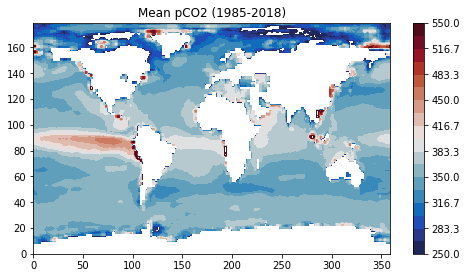

In [17]:
fig = plt.subplots(1,1,figsize=(8,4.25))
plt.contourf(pco2_mean,cmap=cm.cm.balance,levels=np.linspace(250,550,19))
plt.colorbar()
plt.title("Mean pCO2 (1985-2018)")

In [18]:
# Write to file this mean pCO2 estimate:
mean_dir = "/data/artemis/workspace/vbennington/pCO2_products"
fout = f"{mean_dir}/Mean_pCO2_2D_mon_1x1_198501-201812.nc"

ds_out = xr.Dataset(
                        {
                        'pCO2_mean':(["ylat","xlon"],pco2_mean)
                        },
                        coords={'ylat':(['ylat'],products.lat),
                               'xlon':(['xlon'],products.lon)
                               })

ds_out.to_netcdf(fout)

Now have Mean pCO2

Calculate pCO2-T from mean pCO2 and satellite SST

In [19]:
def calc_pCO2T(pco2_mean,sst_series):
    
    # Use climatological pCO2 to calculate pCO2_T
    pCO2_T = pco2_mean * np.exp(0.0423* (sst_series - sst_series.mean("time")))

    pCO2_T = pCO2_T.transpose("time","ylat","xlon")
    
    return pCO2_T

In [39]:
# Load Satellite SST

sat_fname = "/data/artemis/workspace/vbennington/NOAA_SST/processed/SST_mon_198201-202012.nc"

sst_series = xr.open_dataset(f"{sat_fname}").sst[0:-12,:,:]  # Don't need 2020

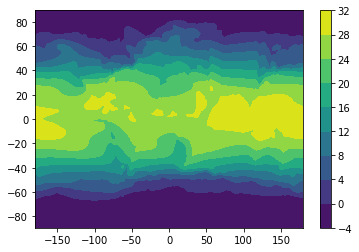

In [40]:
fig = plt.figure()
plt.contourf(sst_series.xlon,sst_series.ylat,sst_series.mean("time"))
plt.colorbar()

In [41]:
# Calculate pCO2-T from mean pCO2 and SST

pCO2_T = calc_pCO2T(pco2_mean,sst_series)

In [24]:
print(pCO2_T)

<xarray.DataArray 'sst' (time: 420, ylat: 180, xlon: 360)>
array([[[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        ...,
        [271.93303177, 273.42627038, 273.42819804, ..., 266.01545737,
         268.93390373, 270.42738242],
        [267.65136719, 265.59609985, 265.59609985, ..., 269.24298096,
         271.76229858, 269.70681763],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]],

       [[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.  

Text(0.5,1,'Mean March pCO2_T')

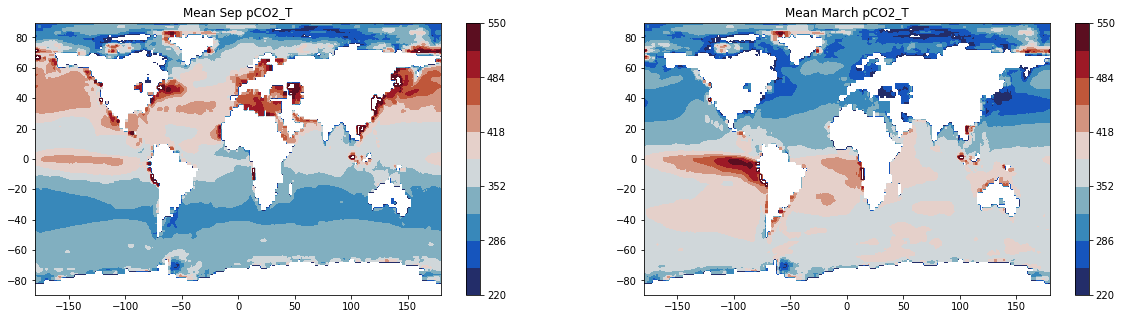

In [42]:
fig,ax = plt.subplots(1,2,figsize=(20,5))
x0=ax[0].contourf(pCO2_T.xlon,pCO2_T.ylat,pCO2_T.groupby("time.month").mean("time")[8,:,:],levels=np.linspace(220,550,11),cmap=cm.cm.balance)
plt.colorbar(x0,ax=ax[0])
ax[0].set_title("Mean Sep pCO2_T")

x0=ax[1].contourf(pCO2_T.xlon,pCO2_T.ylat,pCO2_T.groupby("time.month").mean("time")[2,:,:],levels=np.linspace(220,550,11),cmap=cm.cm.balance)
plt.colorbar(x0,ax=ax[1])
ax[1].set_title("Mean March pCO2_T")

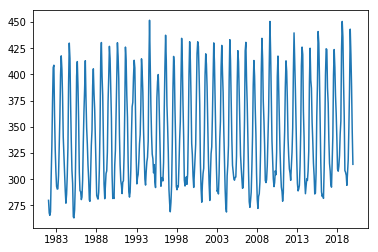

In [43]:
fig = plt.figure()
plt.plot(pCO2_T.time,pCO2_T[:,130,130])

In [44]:
# Write to file pCO2-T:

fout = f"{mean_dir}/product_mean_pCO2T_2D_mon_1x1_198201-201912.nc"

t_out = xr.Dataset(
                        {
                        'pCO2_T':(["time","ylat","xlon"],pCO2_T)
                        },
                        coords={'time':(['time'],pCO2_T.time),
                               'ylat':(['ylat'],pCO2_T.ylat),
                               'xlon':(['xlon'],pCO2_T.xlon)
                               })

t_out.to_netcdf(fout)

In [36]:
# Have mean pCO2
# Have pCO2-T calculated from mean pCO2 and satellite SST
# Have Observed "total" pCO2 at SOCAT sampling locations
# Calculate "pCO2-DIC" = pCO2 - pCO2_T for reconstruction

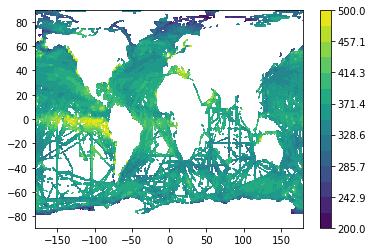

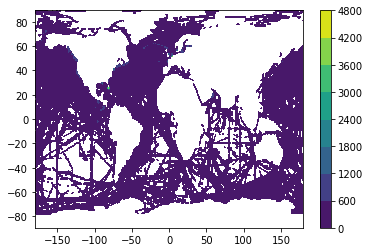

In [45]:
socat_fname = f"{socat_dir}/SOCATv2020_pCO2_gridded_monthly_satelliteSST.nc"

socat_pco2 = xr.open_dataset(f"{socat_fname}").pco2

fig = plt.figure()
plt.contourf(socat_pco2.xlon,socat_pco2.ylat,socat_pco2.mean('time'),levels = np.linspace(200,500,15))
plt.colorbar()

fig = plt.figure()
plt.contourf(socat_pco2.xlon,socat_pco2.ylat,socat_pco2.max('time'))
plt.colorbar()

In [47]:
# Look at the distribution of pCO2-SOCAT

stmp = socat_pco2.stack(z=("time","ylat","xlon"))
stmp2 = stmp[~np.isnan(stmp)]

360.40163319975227
<xarray.DataArray 'pco2' ()>
array(47.32238743)


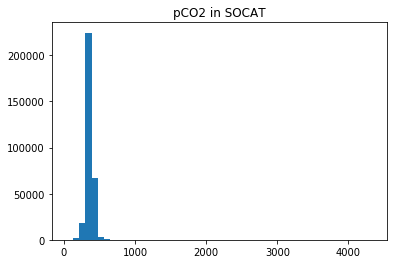

In [48]:
fig = plt.figure()
plt.hist(stmp2,50)
#plt.xlim([-250,250])
plt.title("pCO2 in SOCAT")

print(np.nanmean(stmp2))
print(np.std(stmp2))

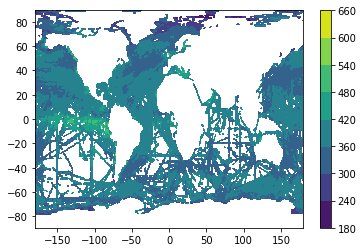

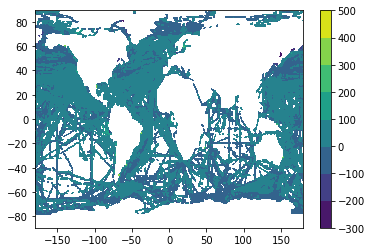

In [49]:
# Get rid of ridiculously high SOCAT pCO2
socat_pco2 = socat_pco2.where(socat_pco2 < 650)
socat_pco2 = socat_pco2.where(socat_pco2 > 200)

fig = plt.figure()
plt.contourf(socat_pco2.xlon,socat_pco2.ylat,socat_pco2.mean('time'))
plt.colorbar()

# Calculate pCO2_DIC

pCO2_DIC = socat_pco2 - pCO2_T

fig = plt.figure()
plt.contourf(pCO2_DIC.xlon,pCO2_DIC.ylat,pCO2_DIC.mean("time"))
plt.colorbar()

In [50]:
# Look at the distribution of pCO2-DIC

tmp = pCO2_DIC.stack(z=("time","ylat","xlon"))

In [51]:
tmp2 = tmp[~np.isnan(tmp)]

Text(0.5,1,'pCO2-DIC in SOCAT')

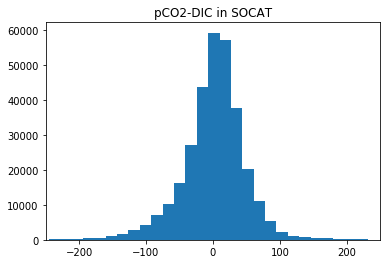

In [52]:
fig = plt.figure()
plt.hist(tmp2,50)
plt.xlim([-250,250])
plt.title("pCO2-DIC in SOCAT")

In [33]:
print((np.nanmean(tmp2)+3*np.std(tmp2)))

<xarray.DataArray ()>
array(145.66922432)


NameError: name 'np' is not defined

In [53]:
# Reconstruct pCO2-DIC from (-200,200)

pCO2_DIC = pCO2_DIC.where((pCO2_DIC >-250) &(pCO2_DIC < 250))

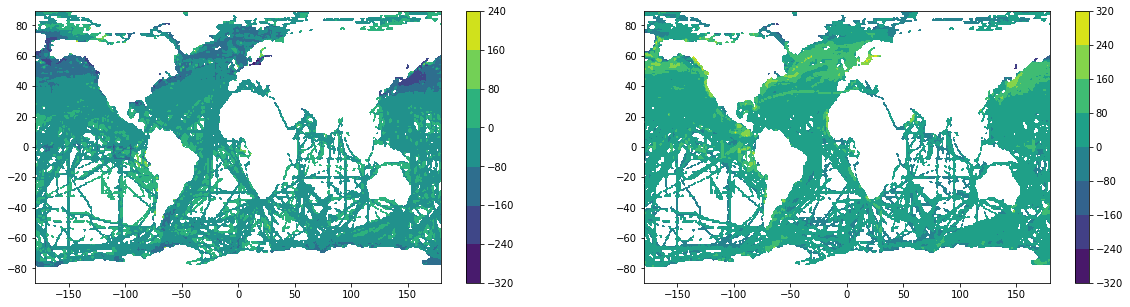

In [54]:
# Where are these observations of large/small pCO2-DIC?

fig,ax = plt.subplots(1,2,figsize=(20,5))
x0=ax[0].contourf(pCO2_DIC.xlon,pCO2_DIC.ylat,pCO2_DIC.min("time"))
plt.colorbar(x0,ax=ax[0])

x0=ax[1].contourf(pCO2_DIC.xlon,pCO2_DIC.ylat,pCO2_DIC.max("time"))
plt.colorbar(x0,ax=ax[1])

In [55]:
# Keep SOCAT pCO2 for comparison only where pCO2-DIC within reason:

socat_pco2 = socat_pco2.where(~np.isnan(pCO2_DIC))

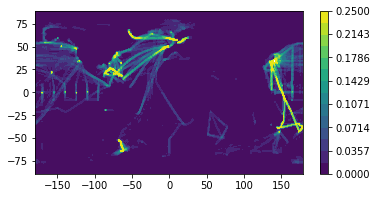

In [56]:
# make a SOCAT mask

socat_mask = socat_pco2.where(~np.isnan(socat_pco2),0)
socat_mask = socat_mask.where(socat_mask==0,1)

fig = plt.figure(figsize=(6,3))
plt.contourf(socat_mask.xlon,socat_mask.ylat,socat_mask.mean("time"),levels=np.linspace(0,.25,15))
plt.colorbar()

In [57]:
# Write out a file with pCO2_DIC, pCO2_T, and SOCAT pCO2

fout = f"{socat_dir}/SOCAT_PRODUCTS_pCO2_pCO2T_pCO2DIC_2D_mon_1x1_198201-201912.nc"

s_out = xr.Dataset(
                        {
                        'pCO2_T':(["time","ylat","xlon"],pCO2_T),
                        'pCO2_DIC':(["time","ylat","xlon"],pCO2_DIC),
                        'pCO2':(["time","ylat","xlon"],socat_pco2),
                        'socat_mask':(["time","ylat","xlon"],socat_mask),
                        'pCO2_mean':(["ylat","xlon"],pco2_mean)    
                        },
                        coords={'time':(['time'],pCO2_T.time),
                               'ylat':(['ylat'],pCO2_T.ylat),
                               'xlon':(['xlon'],pCO2_T.xlon)
                               })

s_out.to_netcdf(fout)